# Cointegration





Installation des packages

In [47]:
#install.packages("googledrive")
#install.packages("readxl")
#install.packages("dplyr")
#install.packages("ggplot2")
#install.packages("reshape")
#install.packages("urca")
#install.packages("vars")
#install.packages("tsDyn")


On étudie les relations entre le prix du pétrole brut et le prix de l'essence aux Etats-Unis. L'essence étant un produit dérivé du pétrole brut, on peut s'attendre à ce que les prix de ces deux produits fluctuent en parallèle. En économie de l'energie la différence entre les deux prix s'appelle le ``[crack spread](https://www.investopedia.com/terms/c/crackspread.asp#:~:text=A%20crack%20spread%20refers%20to,type%20of%20gross%20processing%20margin.)''. Les deux prix peuvent s'éloigner ou se rapprocher temporairement mais avoir un écart stable sur le long terme. La différence entre les deux prix est importante pour la marge de profit des raffineurs. Si les prix sont des processus stationnaires en différence, mesurer le crack spread reviendra à vérifier et estimer l'existence d'une relation de cointégration entre les deux.

Dans cet exercice, on mesure le crack spreand pour le [WTI](https://www.investopedia.com/terms/w/wti.asp) (West Texas intermediate), qui est le prix de référence du pétrole brut aux Etats-Unis, et le prix de l'essence affiché sur le port de New York (il existe d'autre prix de réference de l'essence). Les données proviennent de l'agence américaine  [EIA](https://www.eia.gov/petroleum/) (Energy Information Agency).

## Importation des données à partir d'un fichier .xls


In [48]:
library(googledrive)

In [49]:
drive_download("https://docs.google.com/spreadsheets/d/1MJDNtbiQpu1fVHTpNJ1ubF-MadE2x6Wo/edit?usp=share_link&ouid=116043692381646876229&rtpof=true&sd=true")

File downloaded:

• PET_PRI_SPT_S1_W.xls <id: 1MJDNtbiQpu1fVHTpNJ1ubF-MadE2x6Wo>

Saved locally as:

• PET_PRI_SPT_S1_W.xls




Le fichier des données est en format .xls : on utilise la librairie readxl pour importer les données

In [50]:
library(readxl)

Les données sont contenues sur plusieurs feuilles dans le fichier excel PET_PRI_SPT_S1_W.xls. Les prix du brut sont dans la feuille Data 1, ceux de l'essence (gasoline) dans la feuille Data 2. Les périodes d'observation ne sont pas exactement les mêmes pour les prix du brut que ceux de l'essence. Les prix pour le WTi sont disponibles de jan/03/1986 à juin/30/2023 (1957 observations). Les prix pour l'essence sont disponibles de juin/06/1986 à juin/30/2023 (1935 observations). Le prix du brut est exprimé en dollars par baril et celui de l'essence en dollars par gallon ( 1 baril = 42 US gallons  = 158.987 litres).

In [51]:
oil<-read_xls(path = "PET_PRI_SPT_S1_W.xls",skip=2,sheet = c("Data 1"))
gaso<-read_xls(path = "PET_PRI_SPT_S1_W.xls",skip=2,sheet = c("Data 2"))

On procède à une jointure à droite des dataframe oil et gaso en se restreignant à la période d'observation de l'essence.

In [52]:
library(dplyr)
join_df<-right_join(oil,gaso)
colnames(join_df)<-c('Date','WTI','Brent','NYgaso','Gulfgaso')
str(join_df)
tail(join_df)

Joining with `by = join_by(Date)`


tibble [1,935 × 5] (S3: tbl_df/tbl/data.frame)
 $ Date    : POSIXct[1:1935], format: "1986-06-06" "1986-06-13" ...
 $ WTI     : num [1:1935] 13.2 13.2 13.8 13.6 12.2 ...
 $ Brent   : num [1:1935] NA NA NA NA NA NA NA NA NA NA ...
 $ NYgaso  : num [1:1935] 0.434 0.425 0.417 0.409 0.385 0.346 0.336 0.333 0.316 0.4 ...
 $ Gulfgaso: num [1:1935] 0.416 0.414 0.412 0.399 0.376 0.342 0.332 0.322 0.312 0.39 ...


Date,WTI,Brent,NYgaso,Gulfgaso
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
2023-05-26,72.62,76.48,2.705,2.602
2023-06-02,69.85,73.89,2.634,2.445
2023-06-09,71.56,76.06,2.774,2.495
2023-06-16,69.42,74.39,2.701,2.454
2023-06-23,70.41,75.26,2.568,2.408
2023-06-30,69.36,73.55,2.560,2.364


On choisit d'étudier la relation entre le WTI, prix de référence du pétrole brut aux Etats-Unis, et le prix de l'essence observé au port de New York. Les deux séries sont représentées sur le graphique ci-dessous. Ce graphique montre que :

1. les deux séries ressemblent à des séries non stationnaires,
2. les deux séries évoluent en parallèle.
Les évolutions parallèles des prix suggèrent l'existence d'une relation de cointégration.

Le graphique montre également la chute exceptionnelle des prix en 2020 au moment du déclenchement de la crise du covid.

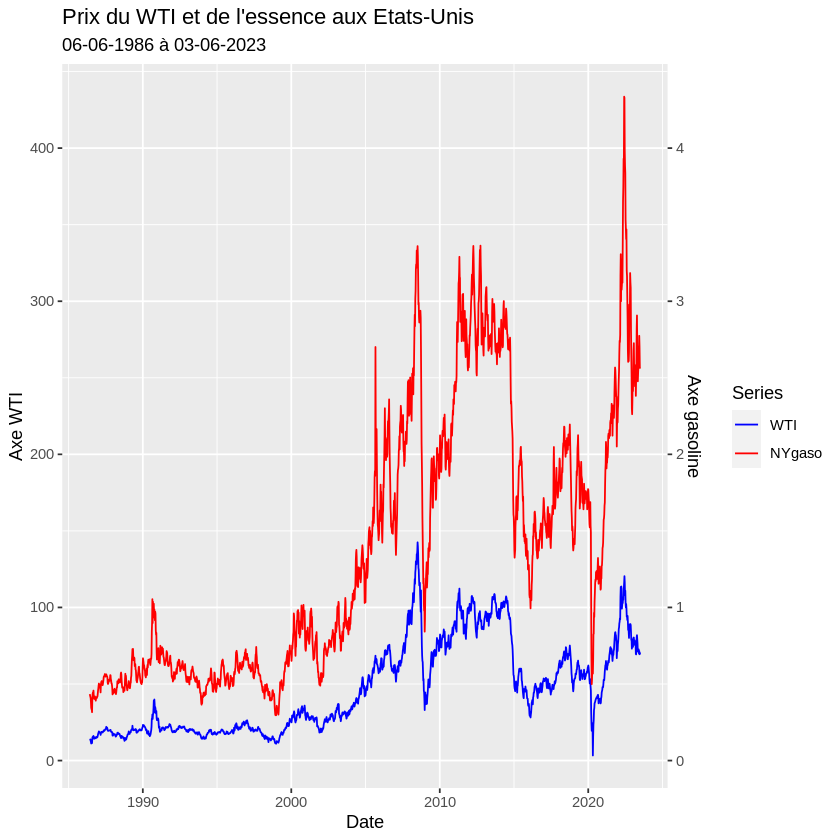

In [53]:
library(ggplot2)
library(reshape)
data_plot=join_df[,c(1,2,4)]
data_plot$NYgaso=data_plot$NYgaso*100
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=Date,y=value,color=variable))+
  scale_y_continuous(
    name="Axe WTI",
    sec.axis = sec_axis(~.*0.01,name="Axe gasoline")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Prix du WTI et de l\'essence aux Etats-Unis",subtitle = "06-06-1986 à 03-06-2023")

Pour l'étude empirique, on considère les séries de prix en logarithme.

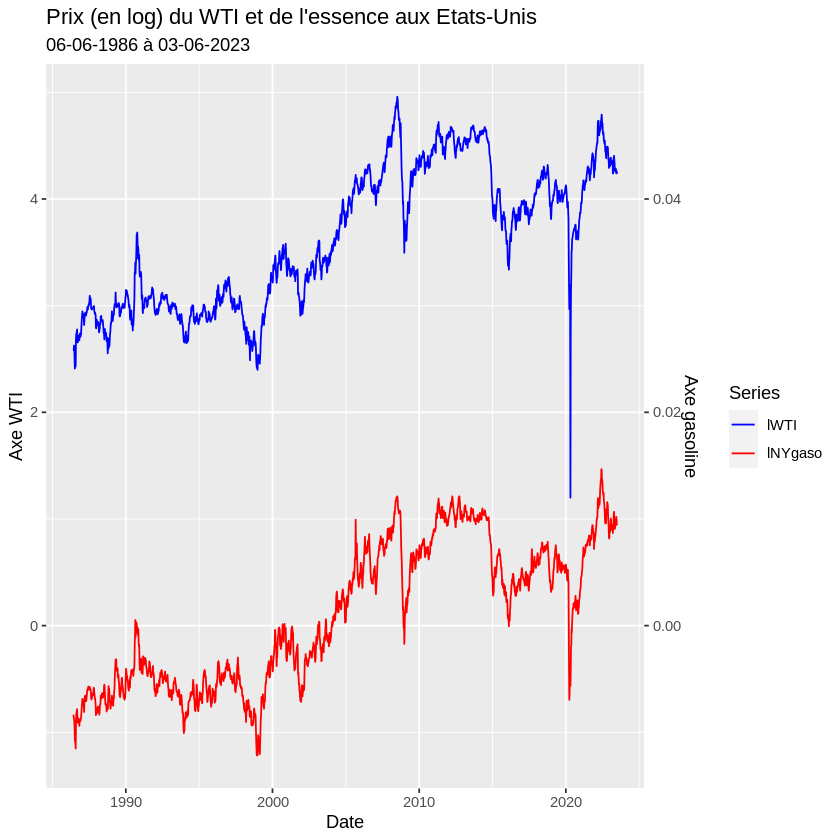

In [54]:
join_df$lWTI <-log(join_df$WTI)
join_df$lNYgaso<-log(join_df$NYgaso)

data_plot=join_df[,c(1,6,7)]
#data_plot$NYgaso=data_plot$NYgaso*100
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=Date,y=value,color=variable))+
  scale_y_continuous(
    name="Axe WTI",
    sec.axis = sec_axis(~.*0.01,name="Axe gasoline")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Prix (en log) du WTI et de l\'essence aux Etats-Unis",subtitle = "06-06-1986 à 03-06-2023")

Le graphique montre les évolutions parallèles des deux séries et aussi la chute importante et ponctuelle en mars 2023. On peut se demander quel sera l'impact de cet épisode sur les résultats des tests statistiques.

## Etude de la cointégration en excluant la période du covid 06/06/1986 à 02/28/2020

On exclut les données à partir de mars 2023.

In [55]:
join_df_short<-join_df[join_df$Date<"2020-03-01",]

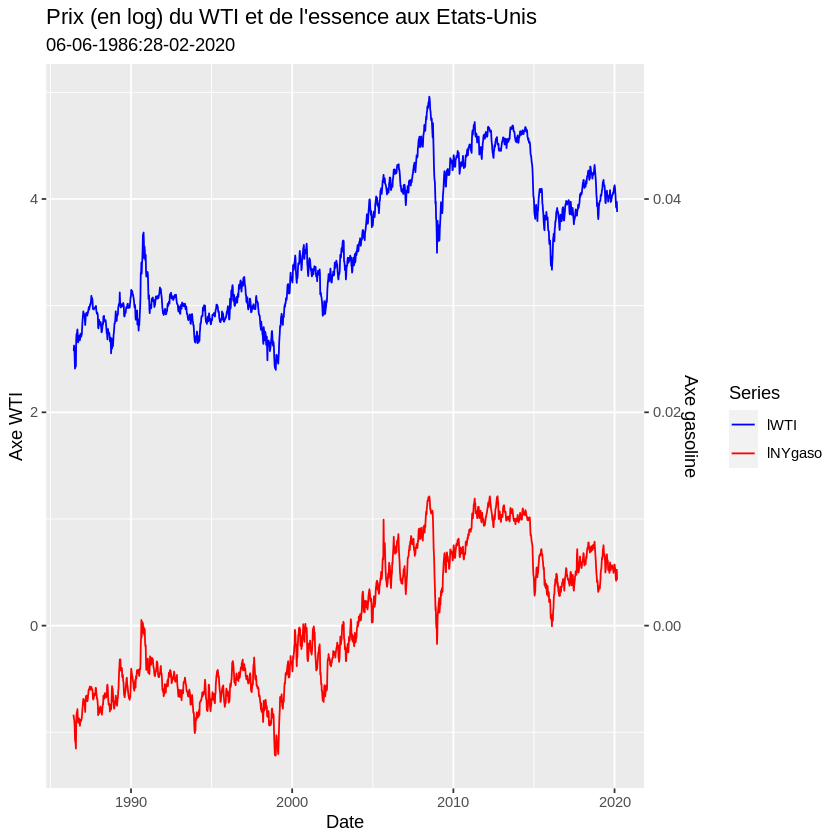

In [56]:
data_plot=join_df_short[,c(1,6,7)]
#data_plot$NYgaso=data_plot$NYgaso*100
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=Date,y=value,color=variable))+
  scale_y_continuous(
    name="Axe WTI",
    sec.axis = sec_axis(~.*0.01,name="Axe gasoline")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Prix (en log) du WTI et de l\'essence aux Etats-Unis",subtitle = "06-06-1986:28-02-2020")


Les deux séries fluctuent en parallèle, il est probable qu'il existe une relation de cointégration elles.


### Caractérisation des deux séries

Dans un premier temps, on vérifie que les deux séries de prix en logarithme sont bien des processus non stationnaire en appliquant le test de Dickey-Fuller augmenté (cf chapitre II). On fixe un nombre de retards maximum de 12 et l'on choisit le nombre de retard optimal par la minimisation du critère AIC.

#### Caractérisation du WTI

In [57]:
library(urca)
adf1<-ur.df(y = join_df_short$lWTI,type=c("trend"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.190750 -0.021940  0.001717  0.023821  0.263696 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.017e-02  7.367e-03   2.738 0.006243 ** 
z.lag.1      -7.136e-03  2.677e-03  -2.666 0.007748 ** 
tt            6.677e-06  3.419e-06   1.953 0.051019 .  
z.diff.lag1   1.434e-01  2.397e-02   5.981 2.68e-09 ***
z.diff.lag2  -6.501e-02  2.423e-02  -2.683 0.007370 ** 
z.diff.lag3   9.727e-02  2.428e-02   4.006 6.44e-05 ***
z.diff.lag4   1.772e-02  2.412e-02   0.735 0.462611    
z.diff.lag5   2.645e-02  2.413e-02   1.096 0.273270    
z.diff.lag6  -3.541e-02  2.410e-02  -1.469 0.141940    
z.diff.lag7  -2.611e-04  2.409e-02  -0.011 0.991351    
z.diff.lag8   8.377e-0

In [58]:
adf2<-ur.df(y = join_df_short$lWTI,type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf2)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.19055 -0.02175  0.00150  0.02366  0.26364 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.010584   0.005497   1.926 0.054327 .  
z.lag.1      -0.002815   0.001507  -1.868 0.061966 .  
z.diff.lag1   0.141583   0.023975   5.905 4.22e-09 ***
z.diff.lag2  -0.067270   0.024225  -2.777 0.005546 ** 
z.diff.lag3   0.095106   0.024275   3.918 9.28e-05 ***
z.diff.lag4   0.014999   0.024100   0.622 0.533793    
z.diff.lag5   0.023772   0.024115   0.986 0.324383    
z.diff.lag6  -0.037922   0.024083  -1.575 0.115527    
z.diff.lag7  -0.002732   0.024073  -0.113 0.909655    
z.diff.lag8   0.081376   0.024025   3.387 0.000722 ***
z.diff.lag9   0.014316   0.023964   0.597 0.5503

In [59]:
adf3<-ur.df(y = join_df_short$lWTI,type=c("none"), lag=12, selectlags = c('AIC'))
summary(adf3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.190118 -0.021964  0.001691  0.023805  0.263274 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
z.lag.1       4.132e-05  2.668e-04   0.155 0.876938    
z.diff.lag1   1.409e-01  2.399e-02   5.875 5.06e-09 ***
z.diff.lag2  -6.822e-02  2.424e-02  -2.815 0.004937 ** 
z.diff.lag3   9.430e-02  2.429e-02   3.882 0.000107 ***
z.diff.lag4   1.410e-02  2.411e-02   0.585 0.558926    
z.diff.lag5   2.284e-02  2.413e-02   0.946 0.344044    
z.diff.lag6  -3.893e-02  2.410e-02  -1.616 0.106369    
z.diff.lag7  -3.600e-03  2.409e-02  -0.149 0.881226    
z.diff.lag8   8.040e-02  2.404e-02   3.345 0.000842 ***
z.diff.lag9   1.296e-02  2.397e-02   0.541 0.588886    
z.diff.lag10  1.816e-02  2.3

En utilisant un risque de première espèce de 5\% pour les tests ADF et les tests sur la composante déterministe, on conclut que le WTI (en log) est  un processus DS sans dérive.

#### Caractérisation du prix de l'essence NYgaso

In [60]:
adf1<-ur.df(y = join_df_short$lNYgaso,type=c("trend"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27257 -0.02592  0.00206  0.02712  0.37082 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.687e-03  3.631e-03  -1.842 0.065692 .  
z.lag.1     -8.946e-03  3.169e-03  -2.823 0.004815 ** 
tt           8.745e-06  4.042e-06   2.163 0.030655 *  
z.diff.lag1  1.479e-01  2.398e-02   6.170 8.46e-10 ***
z.diff.lag2  6.858e-03  2.421e-02   0.283 0.776971    
z.diff.lag3  8.820e-02  2.421e-02   3.644 0.000276 ***
z.diff.lag4 -2.124e-02  2.410e-02  -0.881 0.378242    
z.diff.lag5 -6.074e-04  2.402e-02  -0.025 0.979829    
z.diff.lag6 -5.309e-02  2.402e-02  -2.210 0.027249 *  
z.diff.lag7 -4.578e-02  2.382e-02  -1.921 0.054844 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

In [61]:
adf2<-ur.df(y = join_df_short$lNYgaso,type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf2)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27544 -0.02589  0.00099  0.02728  0.36887 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0008048  0.0010921   0.737 0.461273    
z.lag.1     -0.0031462  0.0016918  -1.860 0.063096 .  
z.diff.lag1  0.1451659  0.0239671   6.057  1.7e-09 ***
z.diff.lag2  0.0038087  0.0241901   0.157 0.874910    
z.diff.lag3  0.0850836  0.0241880   3.518 0.000447 ***
z.diff.lag4 -0.0246063  0.0240779  -1.022 0.306950    
z.diff.lag5 -0.0040885  0.0239908  -0.170 0.864700    
z.diff.lag6 -0.0565082  0.0239972  -2.355 0.018644 *  
z.diff.lag7 -0.0495161  0.0237871  -2.082 0.037522 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0455 on 

In [62]:
adf3<-ur.df(y = join_df_short$lNYgaso,type=c("none"), lag=12, selectlags = c('AIC'))
summary(adf3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27484 -0.02510  0.00175  0.02811  0.36961 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.003058   0.001687  -1.812 0.070126 .  
z.diff.lag1  0.145393   0.023962   6.068 1.59e-09 ***
z.diff.lag2  0.003963   0.024186   0.164 0.869869    
z.diff.lag3  0.085236   0.024184   3.524 0.000435 ***
z.diff.lag4 -0.024430   0.024074  -1.015 0.310335    
z.diff.lag5 -0.003893   0.023986  -0.162 0.871072    
z.diff.lag6 -0.056301   0.023992  -2.347 0.019055 *  
z.diff.lag7 -0.049259   0.023781  -2.071 0.038476 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0455 on 1740 degrees of freedom
Multiple R-squared:  0.03801,	Adjusted R-

En utilisant un risque de première espèce de 5\% pour les tests ADF et les tests sur la composante déterministe, on conclut que le prix de l'essence (en log) est  un processus DS sans dérive. Les deux séries de prix sont donc des processus DS. Il est donc pertinent de tester l'existence d'une relation de cointégration entre elles.

### Test de cointégration de Johansen

#### Etape préliminaire : détermination du nombre de retards pour le test de cointégration



On cherche le nombre de retards optimal pour un modèle VAR des variables lWTI et lNYgaso en minimisant des critères d'information multivariés. On fixe à 12 le nombre de retards maximum et l'on inclut une constante dans chaque équation du VAR. On définit un dataframe contenant uniquement les variables pour lesquelles on teste l'existence de la cointégration

In [63]:
library(vars)
df_oil_gaso<- join_df_short[,c('lWTI','lNYgaso')] # on définit un dataframe qui contient les variables pour lesquelles on teste l'existence de la cointégration
pselect<-VARselect(y=df_oil_gaso,lag.max=12,type=c("const"))

# Affichage des valeurs des critère de sélection
#pselect$criteria
# nombre de retards optimal selon les critères de sélection
pselect$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     9      4      2      9

Le nombre de retards optimal diffère pour chacun des critères. On décide de prendre 4 retards préconisé par le critère HQ. (Les conclusions du test de cointégration de Johansen sur le nombre de relations de cointégration ne varient pas quand on prend 9 ou 2 retards.)

#### Test de cointégration de Johansen

On spécifie le test de cointégration de Johansen :


* **ecdet** : spécifie le terme déterministe que l'on ajoute dans le VECM et la relation de cointégration : "none", "const","trend".

    + ecdet = "none" correspond à constante sans restriction (elle n'apparait pas directement dans la relation de cointégration, mais dans la constante du VECM)
    + ecdet = "const" correspond à constante contrainte (une constante uniquement dans la relation de cointégration)
    + ecdet = "trend" correspond à tendance contrainte (une tendance uniquement dans la relation de cointégration)


* **type** : "trace" pour le test de la trace ou "eigen" pour le test de la valeur propre maximale.
* **K** =  nombre de retards sélectionné pour le VAR sur les prix
* **spec** = spécification du VECM. on utilise la spécification "transitory" qui correspond à celle vu en cours

On inclut une constante dans la relation de cointégration :

*  les deux séries sont des processus DS sans dérive

*  il parait raisonnable d'inclure une constante dans la relation de cointégration, d'après le graphique des deux séries.

On fait le test de la trace (type="trace") et le test de la valeur propre maximale (type = "eigen")


##### Test de la trace

In [64]:
library(urca)
oil_gaso.vecm<-ca.jo(df_oil_gaso,ecdet = "const",spec = "transitory",type = 'trace',K=4)
summary(oil_gaso.vecm)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  3.987663e-02  2.364423e-03 -1.282898e-20

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  4.16  7.52  9.24 12.97
r = 0  | 75.66 17.85 19.96 24.60

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             lWTI.l1 lNYgaso.l1   constant
lWTI.l1     1.000000  1.0000000  1.0000000
lNYgaso.l1 -1.009905  0.1508916  0.0871862
constant   -3.545043 -3.8269648 -1.3325454

Weights W:
(This is the loading matrix)

              lWTI.l1   lNYgaso.l1      constant
lWTI.d    -0.02473141 -0.002459892  2.815444e-18
lNYgaso.d  0.05783243 -0.002359806 -6.850337e-18


On commence parl'hypothèse :
$$\left\lbrace
\begin{array}{l}
H_{0}(0) : r =rang(\Pi)\leq 0\\
H_{a}(0) : r =rang(\Pi)> 0
\end{array}
\right.$$
La statistique du test de la trace est :
$$
Q(0)= -T\sum_{i=1}^{2} ln(1-\hat{\lambda}_{i})=75.66
$$

Le seuil de rejet pour un risque de première espèce de 5 \% est égal à  19.96. On a donc $Q(0)=75.66>19.96$  : on rejette donc l'hypothèse nulle $H_{0}(0) : r =rang(\Pi)\leq 0$ que le nombre de relation de cointégration est égal à 0 pour un risque de première espèce $\alpha = 5\%$. On passe aux hypothèses suivantes :
$$\left\lbrace
\begin{array}{l}
H_{0}(0) : r =rang(\Pi)\leq 1\\
H_{a}(0) : r =rang(\Pi)> 1
\end{array}
\right. $$

La statistique du test de la trace est :
$$
Q(1)= -T ln(1-\hat{\lambda}_{2})=4.16
$$

Le seuil de rejet pour un risque de première espèce de 5\% est égal à  9.24. On a donc $Q(1)=4.16<9.24$  : on ne peut pas rejeter l'hypothèse nulle $H_{0}(1) : r =rang(\Pi)\leq 1$ que le nombre de relation de cointégration est égal à 1 pour un risque de première espèce de 5\%. On conclut qu'il existe une relation de cointégration entre lWTI  et lNYgaso.

##### Test de la valeur propre maximale

In [65]:
oil_gaso.vecm_eigen<-ca.jo(df_oil_gaso,ecdet = "const",spec = "transitory",type = 'eigen',K=4)
summary(oil_gaso.vecm_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  3.987663e-02  2.364423e-03 -1.282898e-20

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  4.16  7.52  9.24 12.97
r = 0  | 71.50 13.75 15.67 20.20

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             lWTI.l1 lNYgaso.l1   constant
lWTI.l1     1.000000  1.0000000  1.0000000
lNYgaso.l1 -1.009905  0.1508916  0.0871862
constant   -3.545043 -3.8269648 -1.3325454

Weights W:
(This is the loading matrix)

              lWTI.l1   lNYgaso.l1      constant
lWTI.d    -0.02473141 -0.002459892  2.815444e-18
lNYgaso.d  0.05783243 -0.002359806 -6.850337e-18


On commence par l'hypothèse :

$$
\left\lbrace
\begin{array}{l}
H_{0} : r = rang(\Pi)= 0\\
H_{a} : r = rang(\Pi)= 1
\end{array}
\right.
$$

La statistique du test de la valeur propre maximale est :

$$
Q(0/1)= -T\sum_{i=1}^{1} ln(1-\hat{\lambda}_{i})=71.50
$$
Le seuil de rejet du test pour un rique de première espèce de 5\% est $15.67< Q(0/1)=71.50$ : on rejette donc l'hypothèse nulle $H_{0}(0) : r =rang(\Pi)\leq 0$ que le nombre de relations de cointégration est égal à 0 pour un risque de première espèce $\alpha = 5\%$. On passe aux hypothèses suivantes :

$$
\left\lbrace
\begin{array}{l}
H_{0}(0) : r =rang(\Pi) = 1\\
H_{a}(0) : r =rang(\Pi) = 2
\end{array}
\right.
$$

La statistique du test de la valeur propre maximale est :

$$
Q(1/2)= -T ln(1-\hat{\lambda}_{2})=4.16
$$

Le seuil de rejet du test pour un rique de première espèce de 5\% est $9.24> Q(1/2)=4.16$ : on ne peut pas rejeter l'hypothèse nulle $H_{0}(1) : r =rang(\Pi)= 1$ que le nombre de relation de cointégration est égal à 1 pour un risque de première espèce de 5\%. On conclut qu'il existe une relation de cointégration entre lwTI et lNYgaso.

### Estimation du VECM



On conclut à l'existence d'une relation de cointégration entre lwTI et lNYgaso. On estime le modèle VECM en imposant une relation de cointégration.

In [66]:
estim_vecm<-cajorls(oil_gaso.vecm,r=1)
summary(estim_vecm$rlm)

Response lWTI.d :

Call:
lm(formula = lWTI.d ~ ect1 + lWTI.dl1 + lNYgaso.dl1 + lWTI.dl2 + 
    lNYgaso.dl2 + lWTI.dl3 + lNYgaso.dl3 - 1, data = data.mat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.187541 -0.022373  0.001958  0.024266  0.266479 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
ect1        -0.02473    0.01105  -2.238 0.025340 *  
lWTI.dl1     0.12104    0.03182   3.804 0.000148 ***
lNYgaso.dl1  0.02734    0.02864   0.955 0.339893    
lWTI.dl2    -0.14028    0.03155  -4.446 9.31e-06 ***
lNYgaso.dl2  0.08414    0.02867   2.935 0.003376 ** 
lWTI.dl3     0.06508    0.03170   2.053 0.040198 *  
lNYgaso.dl3  0.03322    0.02865   1.160 0.246269    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04107 on 1750 degrees of freedom
Multiple R-squared:  0.04273,	Adjusted R-squared:  0.0389 
F-statistic: 11.16 on 7 and 1750 DF,  p-value: 7.009e-14


Response lNYgaso.d :

Call:
lm(formula = lNYgas

On a les deux équations du VECM :

* lWTI.d désigne la variable lWTI en différence première $lWTI.d = lWTI_{t} - lWTI_{t-1}$. idem pour lNYgaso.d
* lWTI.dli désigne la variable lWTI.dli décalée de $i$ retards. idem pour lNYgaso.dli
* ect1 désigne l'écart à la relation de cointégration décalé d'un retard

##### Equation de lWTI.d



* le coefficient (la vitesse d'ajustement) de ect1 est négatif et significatif à 5\%. La relation de cointégration a donc un effet sur la dynamique de lWTI.d. Le signe négatif correspond au signe attendu : quand ect1>0, le prix du brut lWTI en $t-1$ est supérieur à sa valeur de long terme. Le mécanisme à correction d'erreur a tendance à le ramener vers sa valeur de long terme.

* Les coefficients des valeurs retardées de lWTI.di de 1 à 3 sont significatifs au moins à 5\% avec le signe positif pour lWTI.d1 et lWTI.d3 et négatif pour lWTI.d2

* Seul le coefficient de lNYgaso.d2 est significatif et positif.

##### Equation de lNYgaso.d



* le coefficient (la vitesse d'ajustement) de ect1 est positif et significatif à 5\%. La relation de cointégration a donc un effet sur la dynamique de lNYgaso.d. Le signe positif correspond au signe attendu : quand ect1>0, le prix de l'essence lNYgaso en $t-1$ est inférieur à sa valeur de long terme. Le mécanisme à correction d'erreur a tendance à le ramener vers sa valeur de long terme.

* Les coefficients des valeurs retardées de  lWTI.d1 et lWTI.d2 sont significatifs à 5\% avec des signes respectivement positif et négatif.

* Seul le coefficient de lNYgaso.d1 est significatif et positif.


On peut représenter les variables ainsi que la relation de cointégration avec la fonction plot.

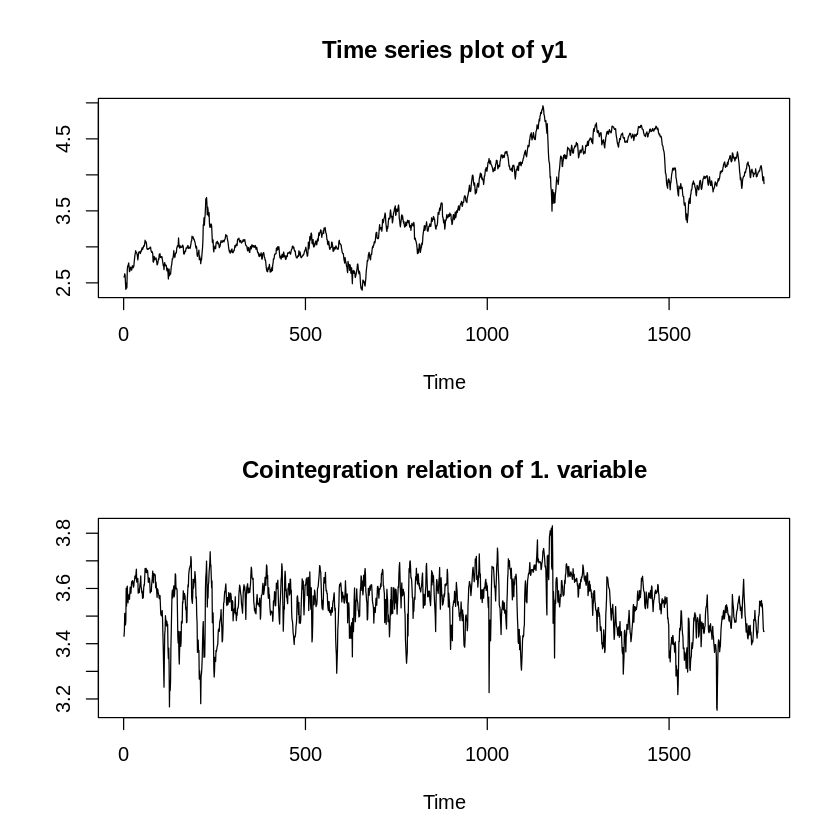

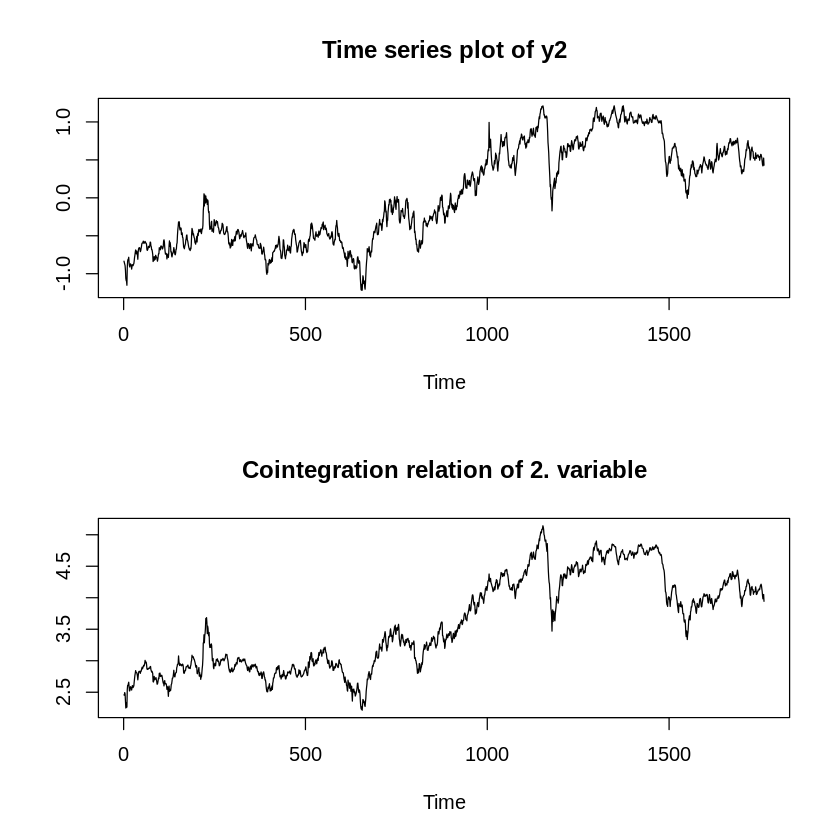

In [67]:
plot(oil_gaso.vecm)


On peut représenter les résidus du VECM et leurs autocorrélogrammes.


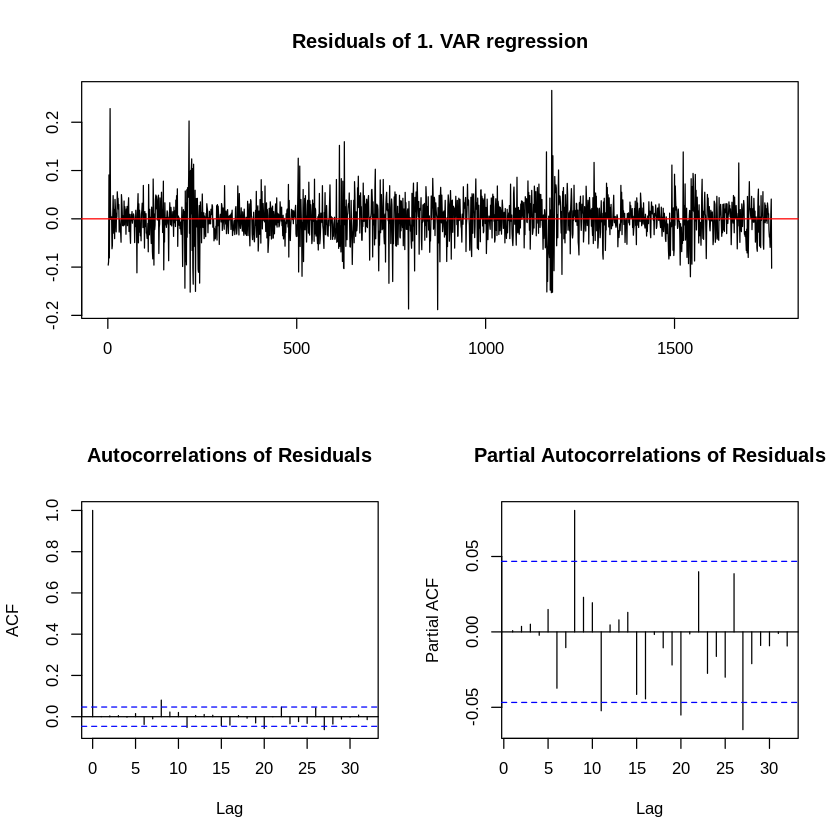

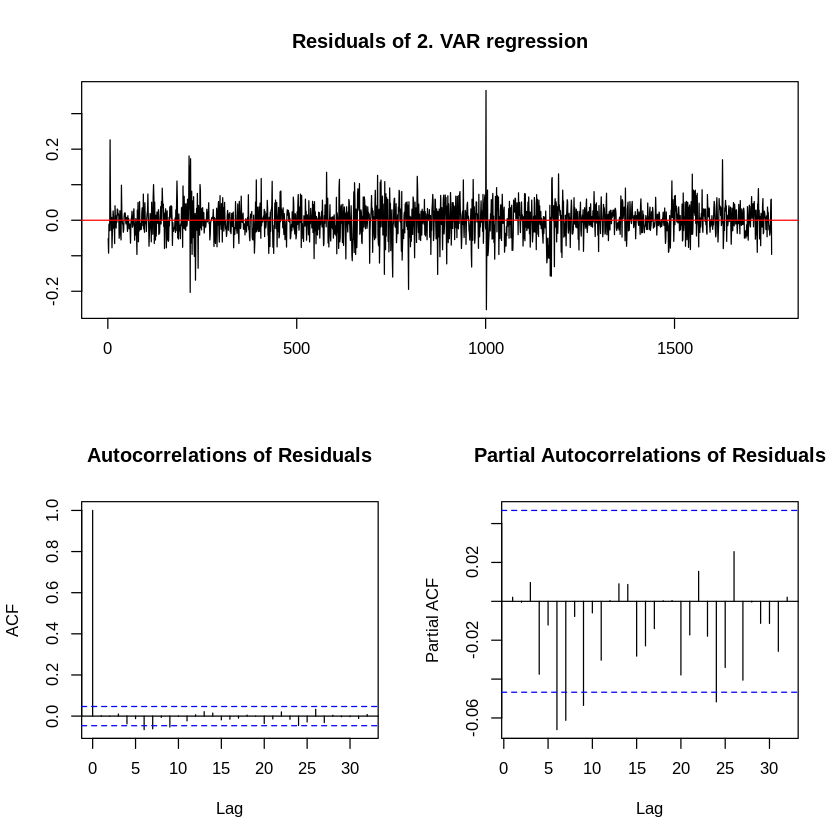

In [68]:
plotres(oil_gaso.vecm)

### Estimation du VECM avec package tsDyn

Le package tsDyn permet aussi d'estimer des modèles VECM en spécifiant la composante déterministe du VECM et de la relation de cointégration. Il permet de specifier 5 modèles :

* include : specification de composante déterministe du VECM, includeLR = specification de la composante déterministe de la relation de cointégration

* pas de constante=> include = none + includeLR =none

* constante non contrainte => include = const + includeLR = none

* constante contrainte => include = none + includeLR = const

* tendance non contrainte => include = both + includeLR = none

* tendance contrainte  => include = none + includeLR = both

In [69]:
library(tsDyn)
VECM_oil_gaso<-VECM(data=df_oil_gaso,lag=3,r=1,estim = "ML",include="none",LRinclude = "const"  )
summary(VECM_oil_gaso)

#############
###Model VECM 
#############
Full sample size: 1761 	End sample size: 1757
Number of variables: 2 	Number of estimated slope parameters 14
AIC -23052.83 	BIC -22970.76 	SSR 6.593624
Cointegrating vector (estimated by ML):
   lWTI   lNYgaso     const
r1    1 -1.009905 -3.545043


                 ECT                lWTI -1           lNYgaso -1        
Equation lWTI    -0.0247(0.0111)*   0.1210(0.0318)*** 0.0273(0.0286)    
Equation lNYgaso 0.0578(0.0123)***  0.0720(0.0353)*   0.1228(0.0318)*** 
                 lWTI -2            lNYgaso -2        lWTI -3           
Equation lWTI    -0.1403(0.0316)*** 0.0841(0.0287)**  0.0651(0.0317)*   
Equation lNYgaso -0.0761(0.0350)*   0.0580(0.0318).   0.0534(0.0352)    
                 lNYgaso -3        
Equation lWTI    0.0332(0.0286)    
Equation lNYgaso 0.0573(0.0318).   

Le graphique ci-dessous montre la dynamique des deux prix en fonction de la valeur de l'écart à la relation de cointégration ECT. On voit que la variation des prix est telle que ECT revient vers 0.

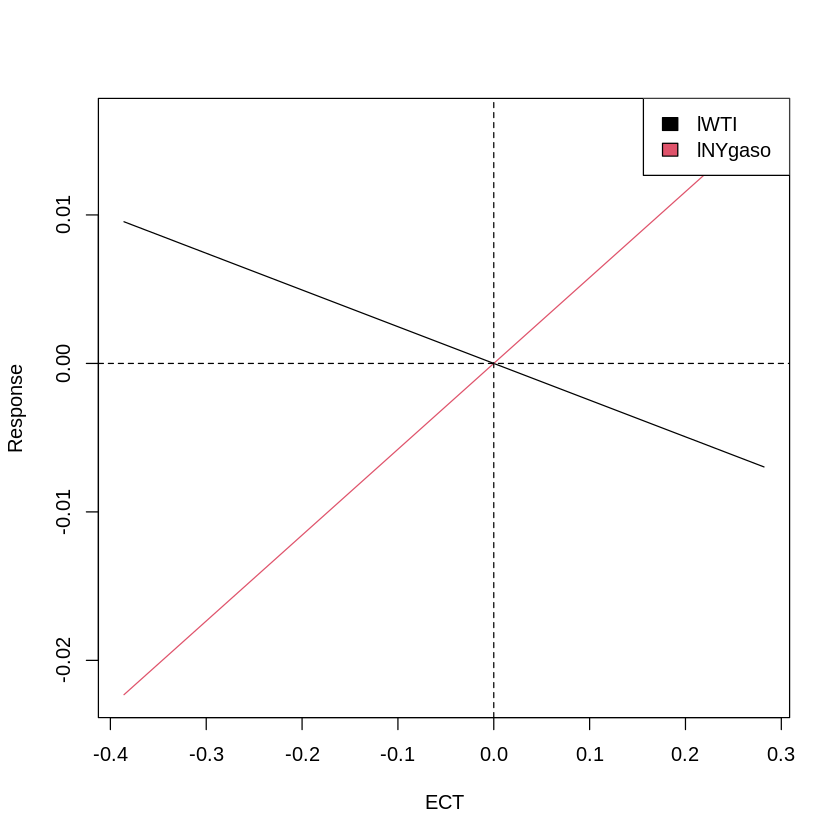

In [70]:
plot_ECT(VECM_oil_gaso, add.legend = TRUE)

## Etude de la cointégration sur la période complète : 06/06/1986 à 06/30/2023

En mars 2020, au début de l'épidémie de covid et du confinement, les prix du pétrole brut et de l'essence ont baissé de manière dramatique. Ces observations constituent des points aberrants (des outliers) qui ne s'expliquent pas par le fonctionnement habituel du marché du pétrole et de ses produits dérivés, mais par un évènement exceptionnel. En faisant baisser le prix, l'épidémie de covid crée une sorte de retour artificiel à la moyenne. En faisant le test de racine unitaire sur toute la période des observations, on risque d'obtenir des résultats plus favorables au rejet de l'hypothèse de racine unitaire.

### Caractérisation des deux séries

#### Caractérisation du WTI

In [71]:
adf1<-ur.df(y = join_df$lWTI,type=c("trend"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.80613 -0.02471  0.00244  0.02674  1.24702 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.873e-02  1.151e-02   3.364 0.000785 ***
z.lag.1     -1.371e-02  4.058e-03  -3.378 0.000745 ***
tt           1.239e-05  4.753e-06   2.607 0.009213 ** 
z.diff.lag1 -1.373e-01  2.287e-02  -6.003 2.31e-09 ***
z.diff.lag2 -1.127e-01  2.307e-02  -4.886 1.12e-06 ***
z.diff.lag3  2.402e-02  2.320e-02   1.035 0.300624    
z.diff.lag4  5.230e-02  2.295e-02   2.279 0.022772 *  
z.diff.lag5  6.688e-02  2.273e-02   2.942 0.003295 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06895 on 1914 degrees of freedom
Multiple R-squared:  0.04

On rejette l'hypothèse nulle de racine unitaire pour un risque de première espèce de 10\%

In [72]:
adf1<-ur.df(y = join_df$lWTI,type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.79282 -0.02491  0.00205  0.02674  1.26744 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.019867   0.008970   2.215  0.02689 *  
z.lag.1     -0.005217   0.002424  -2.152  0.03152 *  
z.diff.lag1 -0.142514   0.022820  -6.245 5.20e-10 ***
z.diff.lag2 -0.117613   0.023027  -5.108 3.59e-07 ***
z.diff.lag3  0.019463   0.023170   0.840  0.40100    
z.diff.lag4  0.048070   0.022926   2.097  0.03614 *  
z.diff.lag5  0.063069   0.022716   2.776  0.00555 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06906 on 1915 degrees of freedom
Multiple R-squared:  0.03898,	Adjusted R-squared:  0.03597 
F-statistic: 12.94 on 6 and 1915 

In [73]:
adf1<-ur.df(y = join_df$lWTI,type=c("none"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.78972 -0.02344  0.00299  0.02707  1.27548 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
z.lag.1      6.873e-05  4.264e-04   0.161  0.87197    
z.diff.lag1 -1.453e-01  2.281e-02  -6.373 2.32e-10 ***
z.diff.lag2 -1.201e-01  2.302e-02  -5.218 2.00e-07 ***
z.diff.lag3  1.727e-02  2.317e-02   0.745  0.45617    
z.diff.lag4  4.622e-02  2.293e-02   2.016  0.04399 *  
z.diff.lag5  6.139e-02  2.273e-02   2.701  0.00697 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06913 on 1916 degrees of freedom
Multiple R-squared:  0.03663,	Adjusted R-squared:  0.03361 
F-statistic: 12.14 on 6 and 1916 DF,  p-value: 1.942e-13


Value of test-statisti

#### Caractérisation du prix de l'essence

In [74]:
adf1<-ur.df(y = join_df$lNYgaso,type=c("trend"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38261 -0.02602  0.00159  0.02789  0.37307 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.657e-03  3.399e-03  -2.253 0.024397 *  
z.lag.1     -1.011e-02  3.030e-03  -3.336 0.000867 ***
tt           9.777e-06  3.573e-06   2.736 0.006275 ** 
z.diff.lag1  1.928e-01  2.281e-02   8.455  < 2e-16 ***
z.diff.lag2  1.163e-02  2.318e-02   0.502 0.615942    
z.diff.lag3  7.572e-02  2.318e-02   3.267 0.001107 ** 
z.diff.lag4 -2.355e-02  2.310e-02  -1.020 0.307994    
z.diff.lag5  9.198e-03  2.304e-02   0.399 0.689776    
z.diff.lag6 -6.121e-02  2.305e-02  -2.656 0.007983 ** 
z.diff.lag7 -4.061e-02  2.271e-02  -1.789 0.073843 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

On rejette l'hypothèse nulle de racine unitaire pour un risque de première espèce de 10\%

In [75]:
adf1<-ur.df(y = join_df$lNYgaso,type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37575 -0.02623  0.00122  0.02771  0.37017 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.001138   0.001107   1.028  0.30410    
z.lag.1     -0.003183   0.001669  -1.907  0.05668 .  
z.diff.lag1  0.190020   0.022824   8.325  < 2e-16 ***
z.diff.lag2  0.008374   0.023187   0.361  0.71803    
z.diff.lag3  0.072428   0.023187   3.124  0.00181 ** 
z.diff.lag4 -0.027176   0.023098  -1.177  0.23952    
z.diff.lag5  0.005490   0.023038   0.238  0.81166    
z.diff.lag6 -0.065000   0.023045  -2.821  0.00484 ** 
z.diff.lag7 -0.044908   0.022692  -1.979  0.04796 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04788 on 1913 degr

In [76]:
adf1<-ur.df(y = join_df$lNYgaso,type=c("none"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37452 -0.02516  0.00230  0.02896  0.37113 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.002912   0.001648  -1.767  0.07743 .  
z.diff.lag1  0.190281   0.022823   8.337  < 2e-16 ***
z.diff.lag2  0.008522   0.023187   0.368  0.71326    
z.diff.lag3  0.072591   0.023187   3.131  0.00177 ** 
z.diff.lag4 -0.027001   0.023098  -1.169  0.24255    
z.diff.lag5  0.005680   0.023037   0.247  0.80529    
z.diff.lag6 -0.064821   0.023044  -2.813  0.00496 ** 
z.diff.lag7 -0.044652   0.022691  -1.968  0.04923 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04788 on 1914 degrees of freedom
Multiple R-squared:  0.05301,	Adjusted R

On rejette l'hypothèse nulle de racine unitaire pour un risque de première espèce de 10 \%.

On voit que pour les deux prix, on est plus près de rejetter l'hypothèse nulle de racine unitaire dans la spécification avec une tendance déterministe que lorsque l'on exclut la période covid.

### Test de cointégration de Johansen

#### Etape préliminaire : détermination du nombre de retards pour le test de cointégration

On cherche le nombre de retards optimal pour un modèle VAR des variables lWTI et lNYgaso en minimisant des critères d'information multivariés. On fixe à 12 le nombre de retards maximum et l'on inclut une constante dans chaque équation du VAR. On définit un dataframe contenant uniquement les variables pour lesquelles on teste l'existence de la cointégration

In [77]:
df_oil_gaso<- join_df[,c('lWTI','lNYgaso')] # on définit un dataframe qui contient les variables pour lesquelles on teste l'existence de la cointégration
pselect<-VARselect(y=df_oil_gaso,lag.max=12,type=c("const"))

# Affichage des valeurs des critère de sélection
#pselect$criteria
# nombre de retards optimal selon les critères de sélection
pselect$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     8      6      3      8

Le nombre de retards optimal est plus elevé que si l'on exclut la période covid. On fait le test de cointégration avec 6 retards

##### Test de la trace

In [78]:
oil_gaso.vecm<-ca.jo(df_oil_gaso,ecdet = "const",spec = "transitory",type = 'trace',K=6)
summary(oil_gaso.vecm)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  3.183478e-02  3.093248e-03 -4.445306e-20

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  5.98  7.52  9.24 12.97
r = 0  | 68.38 17.85 19.96 24.60

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              lWTI.l1 lNYgaso.l1   constant
lWTI.l1     1.0000000   1.000000   1.000000
lNYgaso.l1 -0.9864005   2.537640  -5.345266
constant   -3.5362235  -4.620715 -12.262100

Weights W:
(This is the loading matrix)

              lWTI.l1   lNYgaso.l1      constant
lWTI.d    -0.08246259 -0.001209226  2.525234e-18
lNYgaso.d  0.03458432 -0.001026135 -9.069366e-19


On conclut à l'existence d'une relation de cointégration.

##### Test de la valeur propre maximale

In [79]:
oil_gaso.vecm<-ca.jo(df_oil_gaso,ecdet = "const",spec = "transitory",type = 'eigen',K=6)
summary(oil_gaso.vecm)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  3.183478e-02  3.093248e-03 -4.445306e-20

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  5.98  7.52  9.24 12.97
r = 0  | 62.41 13.75 15.67 20.20

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              lWTI.l1 lNYgaso.l1   constant
lWTI.l1     1.0000000   1.000000   1.000000
lNYgaso.l1 -0.9864005   2.537640  -5.345266
constant   -3.5362235  -4.620715 -12.262100

Weights W:
(This is the loading matrix)

              lWTI.l1   lNYgaso.l1      constant
lWTI.d    -0.08246259 -0.001209226  2.525234e-18
lNYgaso.d  0.03458432 -0.001026135 -9.069366e-19


On conclut à l'existence d'une relation de cointégration. Les résultats des tests de cointégration ne sont donc pas modifiés par l'ajout de la période covid.

### Estimation du VECM


On estime le modèle VECM en imposant une relation de cointégration.

In [80]:
estim_vecm<-cajorls(oil_gaso.vecm,r=1)
summary(estim_vecm$rlm)

Response lWTI.d :

Call:
lm(formula = lWTI.d ~ ect1 + lWTI.dl1 + lNYgaso.dl1 + lWTI.dl2 + 
    lNYgaso.dl2 + lWTI.dl3 + lNYgaso.dl3 + lWTI.dl4 + lNYgaso.dl4 + 
    lWTI.dl5 + lNYgaso.dl5 - 1, data = data.mat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.75474 -0.02448  0.00203  0.02813  0.96123 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
ect1        -0.082463   0.017165  -4.804 1.67e-06 ***
lWTI.dl1    -0.254894   0.028986  -8.794  < 2e-16 ***
lNYgaso.dl1  0.301696   0.038298   7.878 5.54e-15 ***
lWTI.dl2    -0.206631   0.029110  -7.098 1.77e-12 ***
lNYgaso.dl2  0.061413   0.038695   1.587 0.112654    
lWTI.dl3    -0.059868   0.028877  -2.073 0.038287 *  
lNYgaso.dl3  0.091863   0.038328   2.397 0.016636 *  
lWTI.dl4    -0.051375   0.028055  -1.831 0.067217 .  
lNYgaso.dl4  0.116631   0.038269   3.048 0.002338 ** 
lWTI.dl5    -0.003183   0.026611  -0.120 0.904789    
lNYgaso.dl5  0.135963   0.037064   3.668 0.000251 ***
---
Signif. codes:  0 ‘*

La vitesse d'ajustement par à l'écart rapport à la relation de cointégration est plus grande (en valeur absolue) pour l'équation du brut lWTI.d que dans le cas où l'on exclut la période covid.


### Conclusion

On voit que l'inclusion de la période covid peut avoir un certain impact sur les résultats des tests de racine unitaire, dans le sens d'un rejet de l'hypothèse de racine unitaire, mais a peu d'impact sur les conclusions des tests de cointégration, du moins dans notre exemple.